In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import tensorflow as tf

# Prepare the electricity and heat data (target variables)

In [92]:
# First read the electricity usage data
df = pd.read_csv('../data/ele.csv', parse_dates=['date'])
print('shape of data:',df.shape)

# drop the last column
df = df.drop(df.columns[-1], axis=1)

#sum electricity columns
df['electricity'] = df.iloc[:,1:4].sum(axis=1)
df = df.drop(df.columns[1:4], axis=1)

#sum heat columns
df['heat'] = df.iloc[:,1:3].sum(axis=1)
df = df.drop(df.columns[1:3], axis=1)

df.head()

shape of data: (103048, 7)


,date,electricity,heat
0,2018-01-01 01:00:00,8.9,56.900002
1,2018-01-01 01:15:00,8.3,57.389999
2,2018-01-01 01:30:00,8.7,57.299999
3,2018-01-01 01:45:00,9.1,56.090000
4,2018-01-01 02:00:00,8.6,62.100002


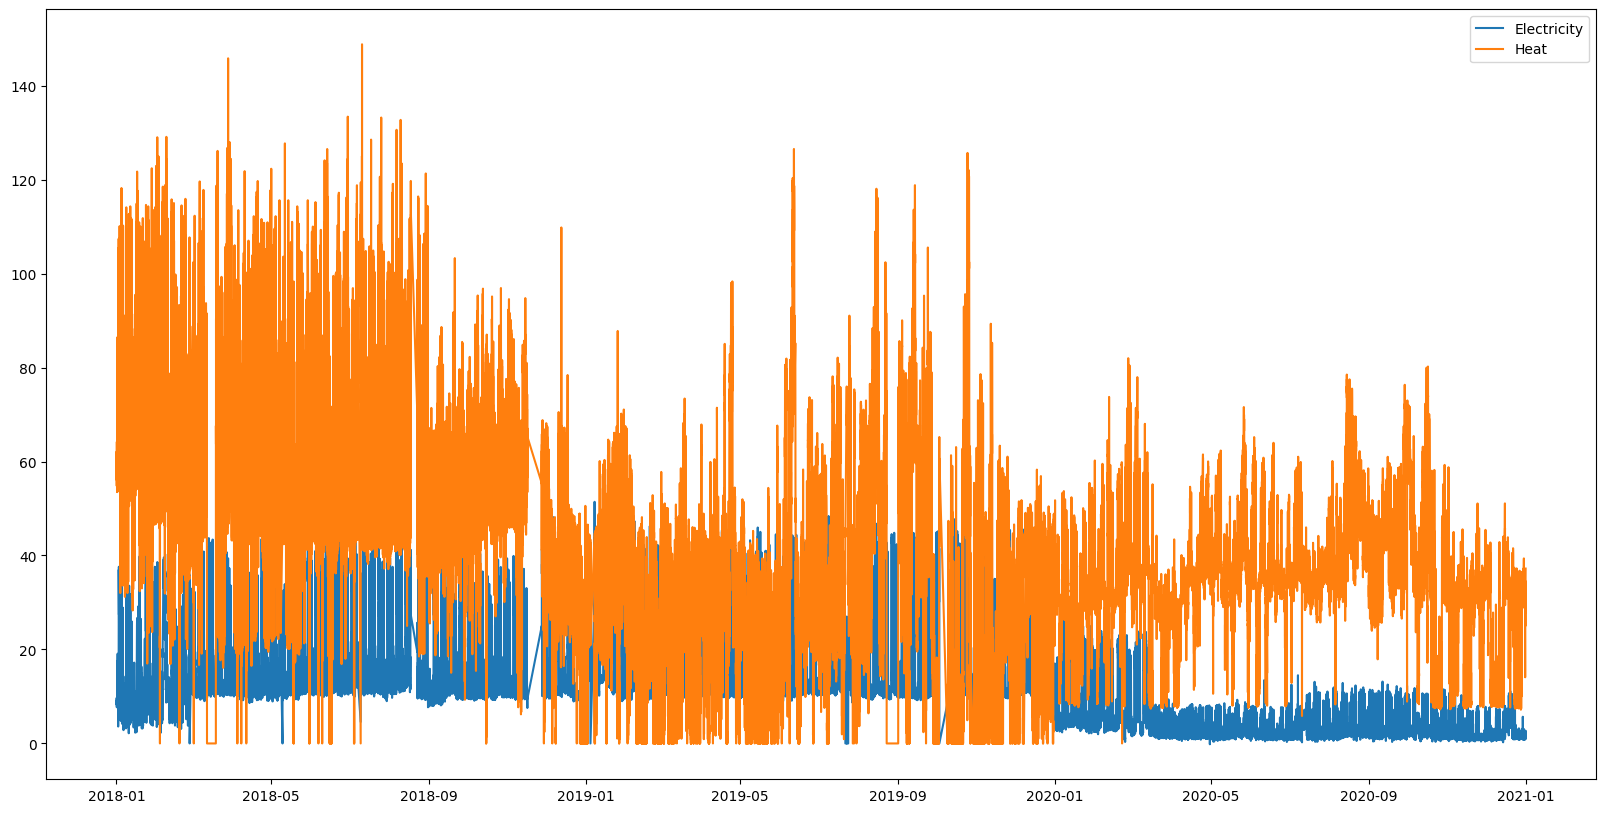

In [93]:
# plot electricity and heat
plt.figure(figsize=(20, 10))
plt.plot(df['date'], df["electricity"], label="Electricity")
plt.plot(df['date'], df["heat"], label="Heat")
plt.legend()
plt.show()

# Prepare the features

In [94]:
df.head()

,date,electricity,heat
0,2018-01-01 01:00:00,8.9,56.900002
1,2018-01-01 01:15:00,8.3,57.389999
2,2018-01-01 01:30:00,8.7,57.299999
3,2018-01-01 01:45:00,9.1,56.090000
4,2018-01-01 02:00:00,8.6,62.100002


In [95]:
features = pd.read_csv('../data/site_weather.csv')
features.head()
df['weather'] = features['air_temp_set_1']
df["hour"] = df['date'].dt.hour
df["day"] = df['date'].dt.dayofweek
df["month"] = df['date'].dt.month
df['seconds'] = df['date'].map(pd.Timestamp.timestamp)

hour = 60*60
day = hour*24
month= day*30.5
year = 365.2425*day

df['hour sin'] = np.sin(df['seconds'] * (2* np.pi / hour))
df['hour cos'] = np.cos(df['seconds'] * (2 * np.pi / hour))
df['day sin'] = np.sin(df['seconds'] * (2* np.pi / day))
df['day cos'] = np.cos(df['seconds'] * (2 * np.pi / day))
df['month sin'] = np.sin(df['seconds'] * (2 * np.pi / month))
df['month cos'] = np.cos(df['seconds'] * (2 * np.pi / month))
df['year sin'] = np.sin(df['seconds'] * (2 * np.pi / year))
df['year cos'] = np.cos(df['seconds'] * (2 * np.pi / year))
df.head()

,date,electricity,heat,weather,hour,day,month,seconds,hour sin,hour cos,day sin,day cos,month sin,month cos,year sin,year cos
0,2018-01-01 01:00:00,8.9,56.900002,11.64,1,0,1,1.514768e+09,-1.840250e-10,1.000000e+00,0.258819,0.965926,-0.902030,0.431673,0.006910,0.999976
1,2018-01-01 01:15:00,8.3,57.389999,11.49,1,0,1,1.514769e+09,1.000000e+00,-2.208653e-10,0.321439,0.946930,-0.901102,0.433608,0.007089,0.999975
2,2018-01-01 01:30:00,8.7,57.299999,11.59,1,0,1,1.514770e+09,-1.600943e-10,-1.000000e+00,0.382683,0.923880,-0.900169,0.435540,0.007268,0.999974
3,2018-01-01 01:45:00,9.1,56.090000,11.44,1,0,1,1.514771e+09,-1.000000e+00,9.932325e-11,0.442289,0.896873,-0.899233,0.437471,0.007447,0.999972
4,2018-01-01 02:00:00,8.6,62.100002,11.12,2,0,1,1.514772e+09,3.855224e-11,1.000000e+00,0.500000,0.866025,-0.898292,0.439400,0.007626,0.999971


In [96]:
# plt.figure(figsize=(20, 10))
# plt.plot(df['date'], df["month cos"], label="month cos")
# plt.plot(df['date'], df["month sin"], label="month sin")
# plt.plot(df['date'], df["year cos"], label="year cos")
# plt.plot(df['date'], df["year sin"], label="year sin")
# plt.plot(df['date'], df["day cos"], label="day cos")
# plt.plot(df['date'], df["day sin"], label="day sin")
# plt.plot(df['date'], df["hour cos"], label="hour cos")
# plt.plot(df['date'], df["hour sin"], label="hour sin")
# plt.xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2018-01-02'))
# plt.legend()
# plt.show()

# Scale the data

In [97]:
df = df.drop(["date"], axis=1)
df.head()

,electricity,heat,weather,hour,day,month,seconds,hour sin,hour cos,day sin,day cos,month sin,month cos,year sin,year cos
0,8.9,56.900002,11.64,1,0,1,1.514768e+09,-1.840250e-10,1.000000e+00,0.258819,0.965926,-0.902030,0.431673,0.006910,0.999976
1,8.3,57.389999,11.49,1,0,1,1.514769e+09,1.000000e+00,-2.208653e-10,0.321439,0.946930,-0.901102,0.433608,0.007089,0.999975
2,8.7,57.299999,11.59,1,0,1,1.514770e+09,-1.600943e-10,-1.000000e+00,0.382683,0.923880,-0.900169,0.435540,0.007268,0.999974
3,9.1,56.090000,11.44,1,0,1,1.514771e+09,-1.000000e+00,9.932325e-11,0.442289,0.896873,-0.899233,0.437471,0.007447,0.999972
4,8.6,62.100002,11.12,2,0,1,1.514772e+09,3.855224e-11,1.000000e+00,0.500000,0.866025,-0.898292,0.439400,0.007626,0.999971


In [98]:

scaler = StandardScaler()
array_scaled = scaler.fit_transform(df)


In [107]:
print('shape of array_scaled:', array_scaled.shape)
print(array_scaled)

shape of array_scaled: (103048, 15)
[[-0.38374318  0.77235033 -0.51227572 ...  0.59869804  0.00511597
   1.42951101]
 [-0.44316961  0.79520713 -0.5409266  ...  0.60144984  0.00536782
   1.42950922]
 [-0.40355199  0.79100892 -0.52182601 ...  0.60419879  0.00561968
   1.42950739]
 ...
 [-1.02324001 -0.27028713  0.14325649 ...  0.01522423  0.01019334
   1.4294662 ]
 [-0.99753897 -0.21726614  0.08060656 ...  0.01827569  0.01044519
   1.42946349]
 [-1.11873718 -0.145787    0.11995377 ...  0.021327    0.01069704
   1.42946074]]


# Sperate the features and the target

In [100]:

array_features_scaled = array_scaled[:, 2:]
array_electricity_scaled = array_scaled[:, 0]
array_heat_scaled = array_scaled[:, 1]
print('array_electricity_scaled', array_electricity_scaled)
print('array_heat_scaled', array_heat_scaled)
print('array_features_scaled', array_features_scaled)

array_electricity_scaled [-0.38374318 -0.44316961 -0.40355199 ... -1.02324001 -0.99753897
 -1.11873718]
array_heat_scaled [ 0.77235033  0.79520713  0.79100892 ... -0.27028713 -0.21726614
 -0.145787  ]
array_features_scaled [[-0.51227572 -1.51652802 -1.50286074 ...  0.59869804  0.00511597
   1.42951101]
 [-0.5409266  -1.51652802 -1.50286074 ...  0.60144984  0.00536782
   1.42950922]
 [-0.52182601 -1.51652802 -1.50286074 ...  0.60419879  0.00561968
   1.42950739]
 ...
 [ 0.14325649  1.66191396  0.00419243 ...  0.01522423  0.01019334
   1.4294662 ]
 [ 0.08060656  1.66191396  0.00419243 ...  0.01827569  0.01044519
   1.42946349]
 [ 0.11995377 -1.66100266  0.50654349 ...  0.021327    0.01069704
   1.42946074]]


# Split data into training and testing sets

In [101]:
sequence_length = 12
X = []
y = []
for i in range(len(array_features_scaled) - sequence_length):
    X.append(array_features_scaled[i : i + sequence_length])
    y.append(array_heat_scaled[i + sequence_length])

X = np.array(X)
y = np.array(y)
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)


# On to the fun part! building the RNN

In [102]:
# Build the deep neural network with LSTM layers
model = tf.keras.Sequential()

# Add the first LSTM layer with return_sequences=True to pass output sequences to the next layer
model.add(tf.keras.layers.GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))

model.add(tf.keras.layers.GRU(32, return_sequences=False))
model.add(tf.keras.layers.Dense(32,activation='relu'))

model.add(tf.keras.layers.Dense(8,activation='relu'))

model.add(tf.keras.layers.Dense(1,activation='linear'))  # Output layer

# Compile the model with a lower learning rate and gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust learning rate
model.compile(loss="mean_absolute_error", optimizer=optimizer)

# Implement Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
epochs = 50
batch_size = 32  # Adjust batch size
hist = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
2576/2576 [==============================] - 31s 11ms/step - loss: 0.5355 - val_loss: 0.4732
Epoch 2/50
2576/2576 [==============================] - 26s 10ms/step - loss: 0.4344 - val_loss: 0.3940
Epoch 3/50
2576/2576 [==============================] - 27s 10ms/step - loss: 0.3801 - val_loss: 0.3691
Epoch 4/50
2576/2576 [==============================] - 27s 10ms/step - loss: 0.3518 - val_loss: 0.3533
Epoch 5/50
2576/2576 [==============================] - 26s 10ms/step - loss: 0.3340 - val_loss: 0.3314
Epoch 6/50
2576/2576 [==============================] - 27s 10ms/step - loss: 0.3221 - val_loss: 0.3217
Epoch 7/50
2576/2576 [==============================] - 27s 10ms/step - loss: 0.3105 - val_loss: 0.3117
Epoch 8/50
2576/2576 [==============================] - 27s 11ms/step - loss: 0.3019 - val_loss: 0.3050
Epoch 9/50
2576/2576 [==============================] - 28s 11ms/step - loss: 0.2950 - val_loss: 0.2972
Epoch 10/50
2576/2576 [==============================] - 28s 11m

In [103]:
# Make predictions on training and testing data
y_train_pred = model.predict(X_train,verbose=0).flatten()
y_test_pred = model.predict(X_test,verbose=0).flatten()

# Rescale the predicitions

In [105]:
y_train_pred_original = scaler.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
y_test_pred_original = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

ValueError: non-broadcastable output operand with shape (82428,1) doesn't match the broadcast shape (82428,15)

# Now, lets evaluate the accuracy of the results

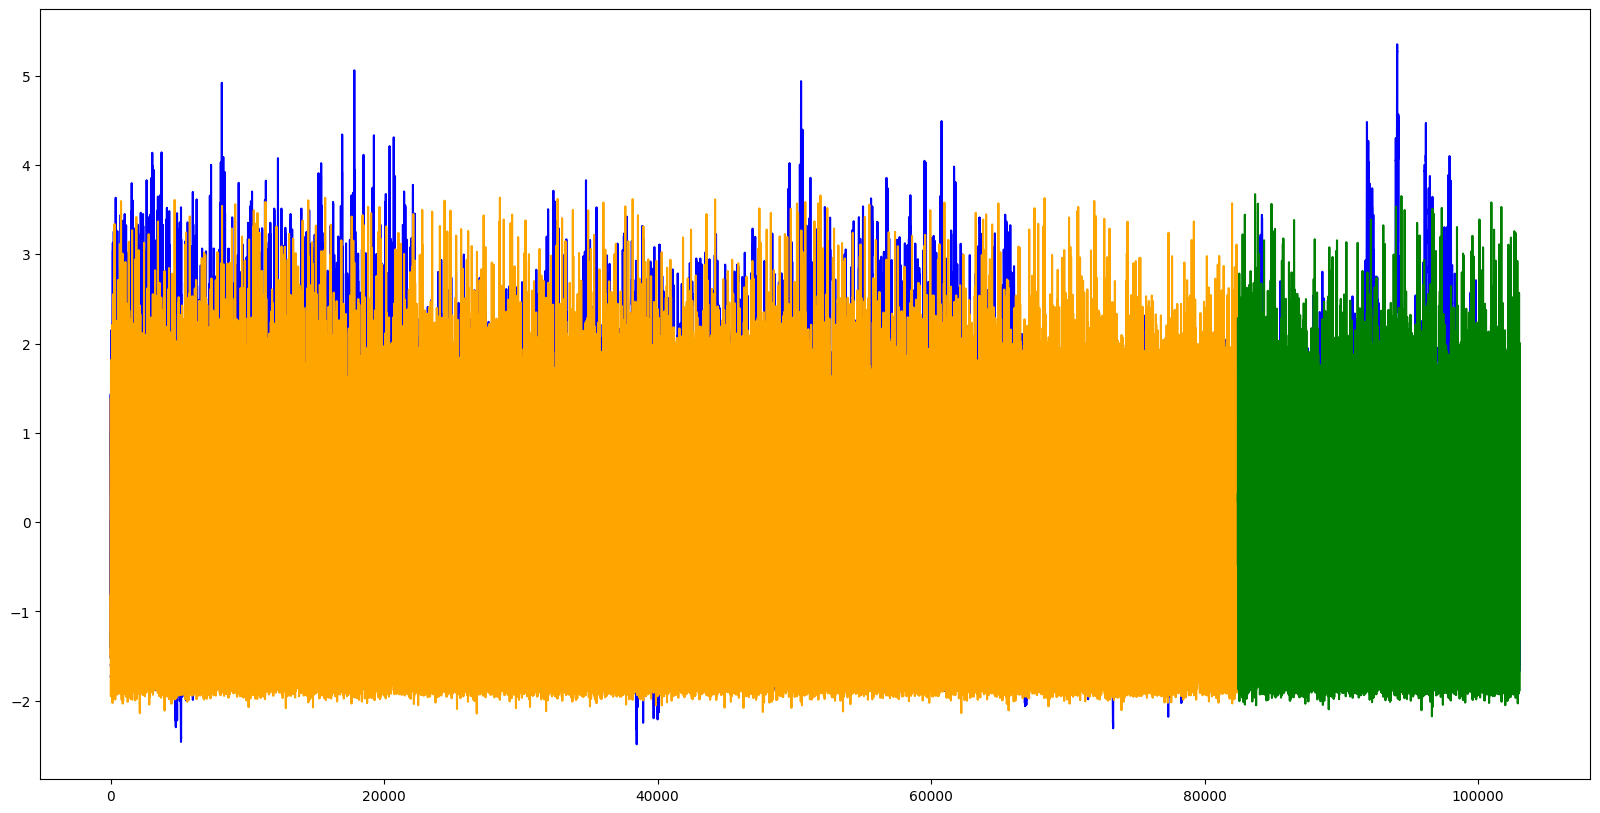

In [111]:

# plot
plt.figure(figsize=(20, 10))
plt.plot(array_scaled, label="Actual", color="blue")
plt.plot(y_train_pred, label="Predicted", color="orange")
plt.plot(
    np.arange(len(y_train_pred), len(y_train_pred) + len(y_test_pred)),
    y_test_pred,
    label="Predicted",
    color="green",
)